# Analysis of Financial Markets based on President Trump's Tweets

## Data Preprocessing

### Importing Data

In [1]:
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file containing your API key
from google.colab import files
files.upload()

In [3]:
!mkdir ~/.kaggle 

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Check to see if the API is working correctly 
# ! kaggle datasets list

In [ ]:
! kaggle datasets download -d austinreese/trump-tweets

In [ ]:
! pip install yfinance

### Data Cleaning

In [8]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
import spacy

#### Twitter Data

In [9]:
data = ZipFile("/content/trump-tweets.zip")
trump_tweets = pd.read_csv(data.open('trumptweets.csv'))
trump_tweets.head()

,id,link,content,date,retweets,favorites,mentions,hashtags,geo
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868,NaN,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273,NaN,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18,NaN,NaN,NaN
3,1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24,NaN,NaN,NaN
4,1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965,NaN,NaN,NaN


In [10]:
trump_tweets.shape

(41122, 9)

The dataframe shows that there are 41,122 rows and 9 columns. Three of these columns mention, hashtags, and geo are currenly showing NaN for the first five rows. 

In [11]:
trump_tweets.describe()

,id,retweets,favorites,geo
count,4.112200e+04,41122.000000,41122.000000,0.0
mean,6.088909e+17,5455.590657,22356.899105,NaN
std,3.027946e+17,10130.076661,41501.859711,NaN
min,1.698309e+09,0.000000,0.000000,NaN
25%,3.549428e+17,25.000000,28.000000,NaN
50%,5.609149e+17,291.000000,247.000000,NaN
75%,7.941218e+17,8778.000000,32970.750000,NaN
max,1.219077e+18,309892.000000,857678.000000,NaN


In [12]:
#Remove NaN and non-important columns
trump_tweets = trump_tweets.drop(labels=['mentions', 'hashtags', 'geo', 'link'], axis='columns')
trump_tweets

,id,content,date,retweets,favorites
0,1698308935,Be sure to tune in and watch Donald Trump on L...,2009-05-04 20:54:25,500,868
1,1701461182,Donald Trump will be appearing on The View tom...,2009-05-05 03:00:10,33,273
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 15:38:08,12,18
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 22:40:15,11,24
4,1773561338,"""My persona will never be that of a wallflower...",2009-05-12 16:07:28,1399,1965
...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Stro...,2020-01-19 19:24:52,32620,213817
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wi...,2020-01-19 22:12:20,36239,149571
41119,1219053709428248576,I was thrilled to be back in the Great State o...,2020-01-20 01:27:07,16588,66944
41120,1219066007731310593,"“In the House, the President got less due proc...",2020-01-20 02:16:00,20599,81921


In [13]:
trump_tweets.dtypes

id            int64
content      object
date         object
retweets      int64
favorites     int64
dtype: object

In [14]:
# The date column is an object when it should be datetime
trump_tweets['date'] = pd.to_datetime(trump_tweets['date'], format='%Y%m%d %H:%M:%S')

In [15]:
# Split the date column into 2 seperate columns
trump_tweets['Time'],trump_tweets['Date']= trump_tweets['date'].apply(lambda x:x.time()), trump_tweets['date'].apply(lambda x:x.date())
trump_tweets = trump_tweets.drop(labels='date',axis='columns')

In [16]:
trump_tweets.head()

,id,content,retweets,favorites,Time,Date
0,1698308935,Be sure to tune in and watch Donald Trump on L...,500,868,20:54:25,2009-05-04
1,1701461182,Donald Trump will be appearing on The View tom...,33,273,03:00:10,2009-05-05
2,1737479987,Donald Trump reads Top Ten Financial Tips on L...,12,18,15:38:08,2009-05-08
3,1741160716,New Blog Post: Celebrity Apprentice Finale and...,11,24,22:40:15,2009-05-08
4,1773561338,"""My persona will never be that of a wallflower...",1399,1965,16:07:28,2009-05-12


In [17]:
trump_tweets['content']

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
41117    I have never seen the Republican Party as Stro...
41118    Now Mini Mike Bloomberg is critical of Jack Wi...
41119    I was thrilled to be back in the Great State o...
41120    “In the House, the President got less due proc...
41121    A great show! Check it out tonight at 9pm. @ F...
Name: content, Length: 41122, dtype: object

We want to clean the tweets through the removal of objects such as hashtags, links to external media, punctuation, and extra spaces that may be in the tweets. 

In [18]:
trump_tweets.content[30889]	

'LIVE on # Periscope: Join me for a few minutes in Pennsylvania. Get out & VOTE tomorrow. LETS # MAGA!!https://www.pscp.tv/w/au-0MDEyMzE3NDF8MXlvS01EQmFNYmx4UXtaU1dFdbs2hR83RLldPOOt9N_C3W-1tUxAlJep-jBY …'

In [19]:
# More Cleaning
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 #text = re.sub('https?://[A-Za-z0-9./]+', '', text) 
 text = re.sub(r"http\S+", '', text) # Removing hyperlink
 text = re.sub('pic.twitter.com/[A-Za-z0-9./]+', '', text) # Remove picture link
 text = re.sub(' +', ' ', text)
 return text

# Clean the tweets
trump_tweets['content'] = trump_tweets['content'].apply(cleanTxt)

# Remove punctuation from content column
trump_tweets['content'] = trump_tweets['content'].str.replace('[^\w\s]','')


In [20]:
trump_tweets.content[30889]	

'LIVE on Periscope Join me for a few minutes in Pennsylvania Get out  VOTE tomorrow LETS MAGA '

In [21]:
pd.set_option("max_colwidth", None)
trump_tweets.head()

,id,content,retweets,favorites,Time,Date
0,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight,500,868,20:54:25,2009-05-04
1,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion,33,273,03:00:10,2009-05-05
2,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman Very funny,12,18,15:38:08,2009-05-08
3,1741160716,New Blog Post Celebrity Apprentice Finale and Lessons Learned Along the Way,11,24,22:40:15,2009-05-08
4,1773561338,My persona will never be that of a wallflower Id rather build walls than cling to them Donald J Trump,1399,1965,16:07:28,2009-05-12


Slice out the rows that are not needed. 

In [22]:
tweets = trump_tweets[trump_tweets['Date'] >= pd.to_datetime('2016-11-08')]
tweets

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08
...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20


#### Stock Market Data

The Yahoo Finance API is utilized for market data from November 8th 2016 through present day.

In [23]:
import yfinance as yf
market_data = yf.download('NDAQ',start='2016-11-08', end='2020-01-20')
market_data.to_csv('market_data.csv')

[*********************100%***********************]  1 of 1 completed


In [24]:
stock_data = pd.read_csv('/content/market_data.csv')
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.440002,65.570000,64.190002,65.379997,60.622059,666500
1,2016-11-09,65.209999,67.139999,64.690002,66.930000,62.059265,1034000
2,2016-11-10,67.489998,68.290001,66.889999,67.099998,62.216900,1211200
3,2016-11-11,66.980003,67.320000,65.870003,66.440002,61.604923,889400
4,2016-11-14,66.620003,66.660004,64.570000,64.730003,60.019367,1413300


In [25]:
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
798,2020-01-13,107.000000,107.529999,106.830002,107.089996,105.745445,394800
799,2020-01-14,107.260002,107.260002,106.330002,106.550003,105.212227,705200
800,2020-01-15,106.400002,108.209999,106.400002,107.860001,106.505775,623200
801,2020-01-16,108.559998,108.639999,107.779999,108.309998,106.950127,1085300
802,2020-01-17,108.459999,109.370003,108.029999,109.309998,107.937569,790800


In [26]:
stock_data.shape

(803, 7)

In [27]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [28]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,803.000000,803.000000,803.000000,803.000000,803.000000,8.030000e+02
mean,84.331968,84.973026,83.659589,84.344396,80.909229,8.490504e+05
std,11.677265,11.762641,11.554972,11.670628,12.539887,3.644722e+05
min,63.700001,64.320000,63.360001,63.549999,58.925240,2.179000e+05
25%,74.205002,74.744999,73.669998,74.334999,69.955349,5.935500e+05
50%,85.410004,86.190002,84.459999,85.290001,82.019234,7.687000e+05
75%,93.055000,93.605000,92.330002,93.060001,89.404526,1.018850e+06
max,108.559998,109.370003,108.029999,109.309998,107.937569,2.973800e+06


In [29]:
# Round columns with decimal places to only 2 decimal places
stock_data = stock_data.round(decimals=2)
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.44,65.57,64.19,65.38,60.62,666500
1,2016-11-09,65.21,67.14,64.69,66.93,62.06,1034000
2,2016-11-10,67.49,68.29,66.89,67.10,62.22,1211200
3,2016-11-11,66.98,67.32,65.87,66.44,61.60,889400
4,2016-11-14,66.62,66.66,64.57,64.73,60.02,1413300
...,...,...,...,...,...,...,...
798,2020-01-13,107.00,107.53,106.83,107.09,105.75,394800
799,2020-01-14,107.26,107.26,106.33,106.55,105.21,705200
800,2020-01-15,106.40,108.21,106.40,107.86,106.51,623200
801,2020-01-16,108.56,108.64,107.78,108.31,106.95,1085300


In [30]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       803 non-null    datetime64[ns]
 1   Open       803 non-null    float64       
 2   High       803 non-null    float64       
 3   Low        803 non-null    float64       
 4   Close      803 non-null    float64       
 5   Adj Close  803 non-null    float64       
 6   Volume     803 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 44.0 KB


There is not much cleaning that needs to take place for the stock market data. 

## Exploratory Analysis

In [31]:
import seaborn as sns 
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')

### Null Values in Tweets

Now that the data is cleaned up, lets preform some exploritory anlaysis for the 2 data sets.

In [32]:
tweets.isnull().sum()

id           0
content      0
retweets     0
favorites    0
Time         0
Date         0
dtype: int64

In [33]:
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no missing values for either of the data sets. 

### Dates of Tweets

In [34]:
tweets.head()

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08


In [35]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
tweets['Date'].describe

<bound method NDFrame.describe of 30889   2016-11-08
30890   2016-11-08
30891   2016-11-08
30892   2016-11-08
30893   2016-11-08
           ...    
41117   2020-01-19
41118   2020-01-19
41119   2020-01-20
41120   2020-01-20
41121   2020-01-20
Name: Date, Length: 10233, dtype: datetime64[ns]>

In [37]:
tweets.head()

,id,content,retweets,favorites,Time,Date
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08


In [38]:
tweets['Day'] = tweets['Date'].dt.day
tweets['Month'] = tweets['Date'].dt.month
tweets['Year'] = tweets['Date'].dt.year
tweets['Month_Year'] =  tweets['Month'].map(str) + '-' + tweets['Year'].map(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [39]:
tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016


In [40]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10233 entries, 30889 to 41121
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          10233 non-null  int64         
 1   content     10233 non-null  object        
 2   retweets    10233 non-null  int64         
 3   favorites   10233 non-null  int64         
 4   Time        10233 non-null  object        
 5   Date        10233 non-null  datetime64[ns]
 6   Day         10233 non-null  int64         
 7   Month       10233 non-null  int64         
 8   Year        10233 non-null  int64         
 9   Month_Year  10233 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 879.4+ KB


<BarContainer object of 5 artists>

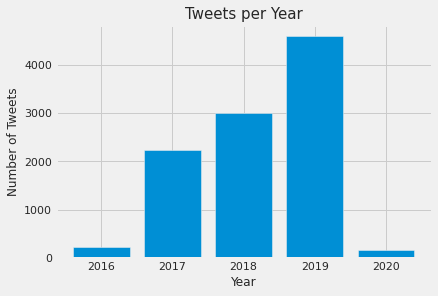

In [41]:
tweets_per_year = {}
for i in tweets['Year']:
  if i not in tweets_per_year:
    tweets_per_year[i] = 1
  else:
    tweets_per_year[i] += 1

keys = tweets_per_year.keys()
values = tweets_per_year.values()

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Tweets per Year", fontsize=15)
plt.bar(keys,values)

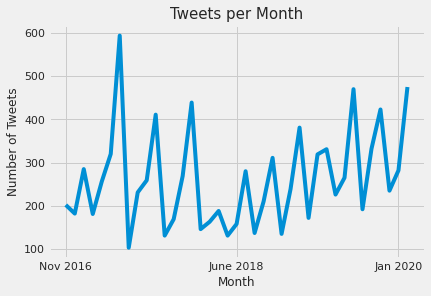

In [42]:
tweets_per_month = {}
for i in tweets['Month_Year']:
  if i not in tweets_per_month:
    tweets_per_month[i] = 1
  else:
    tweets_per_month[i] += 1

lists = sorted(tweets_per_month.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Tweets per Month", fontsize=15)
plt.xticks([0, 19, 37], ['Nov 2016', 'June 2018', 'Jan 2020'])
plt.show()

### Content of Tweets

In [43]:
tweet = tweets['content']
tweet

30889                                                                                                                                                                                    LIVE on Periscope Join me for a few minutes in Pennsylvania Get out  VOTE tomorrow LETS MAGA 
30890                                                                                                                                                                  Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here  The big vote tomorrow
30891                                                                                                             Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont   bei WilkesBarreScranton International Airport AVP
30892                                                                                                                                                   Big news to

In [44]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
def most_used_words(text):
    tokens = word_tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(tokens)))
    return sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [45]:
most_used_words(tweet.str.cat())[:5]

There is 24424 different words


['the', 'to', 'and', 'of', 'a']

### Plot Market Data 

In [46]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-08,65.44,65.57,64.19,65.38,60.62,666500
1,2016-11-09,65.21,67.14,64.69,66.93,62.06,1034000
2,2016-11-10,67.49,68.29,66.89,67.10,62.22,1211200
3,2016-11-11,66.98,67.32,65.87,66.44,61.60,889400
4,2016-11-14,66.62,66.66,64.57,64.73,60.02,1413300


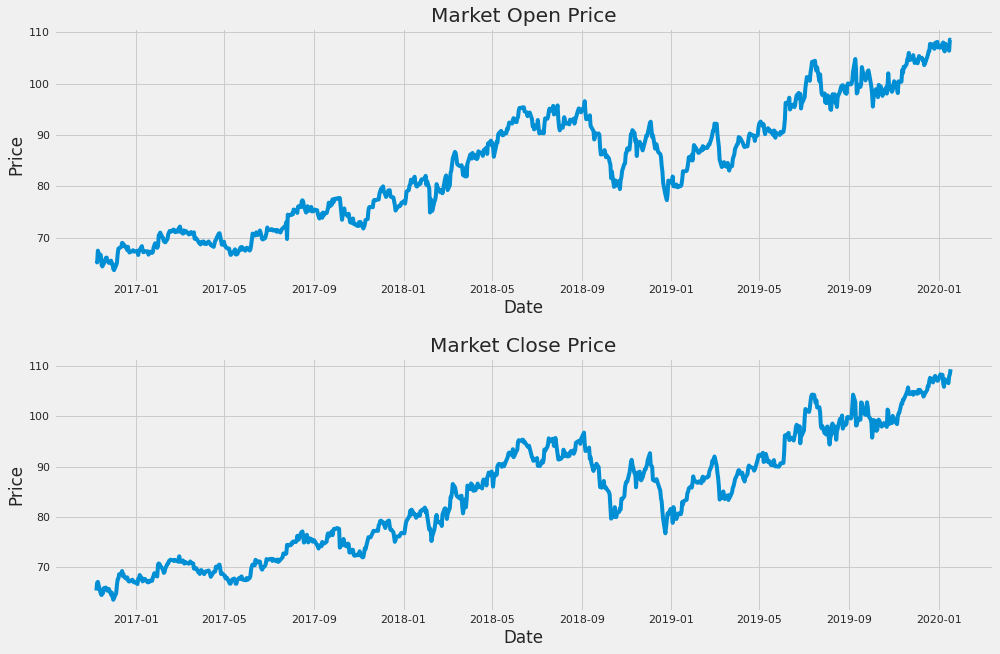

In [47]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.plot(stock_data['Date'], stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title('Market Open Price')
plt.subplots_adjust(hspace=0.3)
ax2.plot(stock_data['Date'], stock_data['Close'])
ax2.set_xlabel("Date")
ax2.set_ylabel("Price")
ax2.set_title('Market Close Price')
plt.show()

Calculate Moving Average

In [48]:
stock_data["SMA1"] = stock_data['Close'].rolling(window=50).mean()
stock_data["SMA2"] = stock_data['Close'].rolling(window=200).mean()

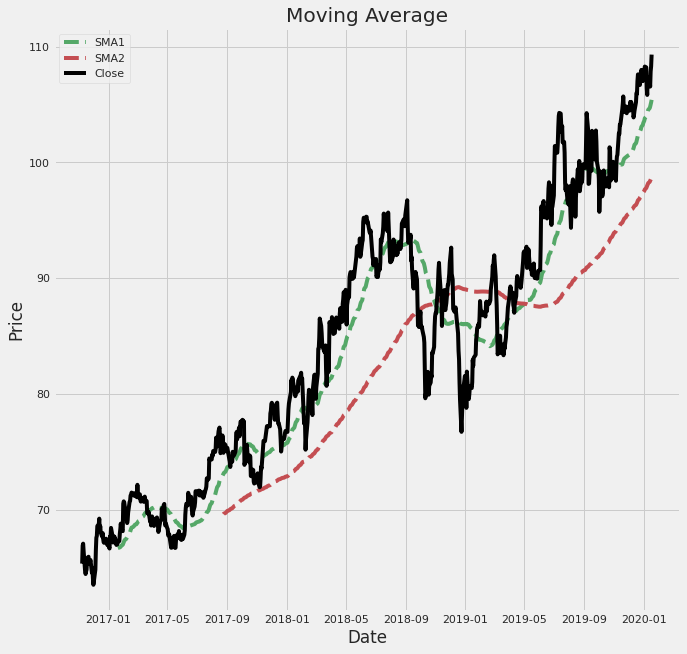

In [49]:
plt.figure(figsize=(10,10))
plt.plot(stock_data['Date'], stock_data['SMA1'], 'g--', label="SMA1")
plt.plot(stock_data['Date'], stock_data['SMA2'], 'r--', label="SMA2")
plt.plot(stock_data['Date'], stock_data['Close'], color='black', label="Close")
plt.title("Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot()
plt.legend()
plt.show()

In [50]:
stock_data = stock_data.drop(['SMA1', 'SMA2'], axis=1)

## Sentiment Analysis

In [51]:
from textblob import TextBlob
from wordcloud import WordCloud

In [52]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
tweets['Subjectivity'] = tweet.apply(getSubjectivity)
tweets['Polarity'] = tweet.apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016,0.300000,-0.031818
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016,0.277273,0.068182
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016,0.000000,0.000000
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016,0.326136,0.234091
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016,0.818182,0.128788
...,...,...,...,...,...,...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19,19,1,2020,1-2020,0.634524,0.359524
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19,19,1,2020,1-2020,0.450000,-0.175000
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20,20,1,2020,1-2020,0.678571,0.382540
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20,20,1,2020,1-2020,0.425417,-0.132917


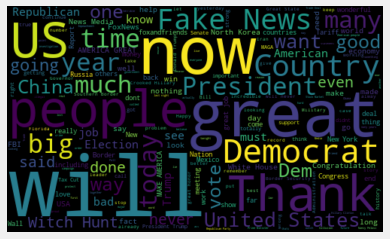

In [53]:
# word cloud visualization
allWords = ' '.join([twts for twts in tweet])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [54]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

tweets['Analysis'] = tweets['Polarity'].apply(getAnalysis)# Show the dataframe
tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
30889,795770006306861057,LIVE on Periscope Join me for a few minutes in Pennsylvania Get out VOTE tomorrow LETS MAGA,8765,27429,00:28:48,2016-11-08,8,11,2016,11-2016,0.300000,-0.031818,Negative
30890,795779987152523264,Thank you Pennsylvania Going to New Hampshire now and on to Michigan Watch PA rally here The big vote tomorrow,7743,25771,01:08:28,2016-11-08,8,11,2016,11-2016,0.277273,0.068182,Positive
30891,795781945607278592,Today in Florida I pledged to stand with the people of Cuba and Venezuela in their fight against oppression cont bei WilkesBarreScranton International Airport AVP,12110,32433,01:16:15,2016-11-08,8,11,2016,11-2016,0.000000,0.000000,Neutral
30892,795782371895349250,Big news to share in New Hampshire tonight Polls looking great See you soon bei WilkesBarreScranton International Airport AVP,11281,38360,01:17:57,2016-11-08,8,11,2016,11-2016,0.326136,0.234091,Positive
30893,795834203430645760,Unbelievable evening in New Hampshire THANK YOU Flying to Grand Rapids Michigan now Watch NH rally here,7796,28222,04:43:54,2016-11-08,8,11,2016,11-2016,0.818182,0.128788,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41117,1218962544372670467,I have never seen the Republican Party as Strong and as Unified as it is right now Thank you,32620,213817,19:24:52,2020-01-19,19,1,2020,1-2020,0.634524,0.359524,Positive
41118,1219004689716412416,Now Mini Mike Bloomberg is critical of Jack Wilson who saved perhaps hundreds of people in a Church because he was carrying a gun and knew how to use it Jack quickly killed the shooter who was beginning a rampage Mini is against the 2nd A His ads are Fake just like him,36239,149571,22:12:20,2020-01-19,19,1,2020,1-2020,0.450000,-0.175000,Negative
41119,1219053709428248576,I was thrilled to be back in the Great State of Texas tonight where the people are known for being tough strong hardworking loyal and fiercely patriotic just like Americas incredible Farmers AFBF2020,16588,66944,01:27:07,2020-01-20,20,1,2020,1-2020,0.678571,0.382540,Positive
41120,1219066007731310593,In the House the President got less due process than the 911 terrorists got This is a corrupt process Mark Levin marklevinshow Very much so RepDougCollins FoxNews,20599,81921,02:16:00,2020-01-20,20,1,2020,1-2020,0.425417,-0.132917,Negative


In [55]:
# Print positive tweets
print('Printing positive tweets:\n')
j=1
sortedDF = tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Streaming output truncated to the last 5000 lines.
3316) Unprecedented success for our Country in so many ways since the Election Record Stock Market Strong on Military Crime Borders  ISIS Judicial Strength  Numbers Lowest Unemployment for Women  ALL Massive Tax Cuts end of Individual Mandate  and so much more Big 2018

3317) Senate is working hard on Americas Transportation Infrastructure Act Will have BIG IMPACT on our highways and roads all across our Nation Interest strong from Republicans and Democrats Do I hear the beautiful word BIPARTISAN Get it done I am with you

3318) My friend and very early supporter Kris Kobach won the Republican Nomination for Governor of Kansas last night in a tough race against a very fine opponent Kris will win in November and be a great Governor He has my complete and total Endorsement

3319) Just finished reading my son Donalds just out new book Triggered It is really good He along with many of us was very unfairly treated But we all fight back and 

In [56]:
# Print negative tweets
print('Printing negative tweets:\n')
j=1
sortedDF = tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing negative tweets:

1) This isnt some game You are screwing with the work of the president of the United States John Dowd March 2018 With North Korea China the Middle East and so much more there is not much time to be thinking about this especially since there was no Russian Collusion

2) Few if any Administrations have done more in just 7 months than the Trump A Bills passed regulations killed border military ISIS SC

3) The Federal Reserve loves watching our manufacturers struggle with their exports to the benefit of other parts of the world Has anyone looked at what almost all other countries are doing to take advantage of the good old USA Our Fed has been calling it wrong for too long

4) cameras running Another False Accusation Why doesnt  washingtonpost report the story of the women taking money to make up stories about me One had her home mortgage paid off Only  FoxNews so reporteddoesnt fit the Mainstream Media narrative

5) Americas police officers have earned the everl

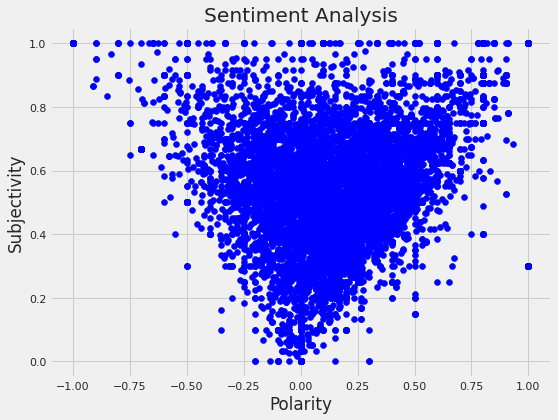

In [57]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(tweets["Polarity"][i], tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

### The Impeachment of President Trump

In [58]:
impeachment_tweets = tweets[tweets['Date'] >= pd.to_datetime('2019-11-01')]
impeachment_tweets = impeachment_tweets[impeachment_tweets['Date'] <= pd.to_datetime('2019-12-26')]
impeachment_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
40091,1190067978089439239,The home of Nancy Pelosi I cant believe her voters can be happy with the job she and the Do Nothing Democrats are doing San Francisco has really gone down hill So sad,19889,71150,01:48:11,2019-11-01,1,11,2019,11-2019,0.622222,0.086111,Positive
40092,1190079191355670529,1600 Pennsylvania Avenue the White House is the place I have come to love and will stay for hopefully another 5 years as we MAKE AMERICA GREAT AGAIN but my family and I will be making Palm Beach Florida our Permanent Residence I cherish New York and the people of,23414,110209,02:32:44,2019-11-01,1,11,2019,11-2019,0.451136,0.359091,Positive
40093,1190079192358105088,New York and always will but unfortunately despite the fact that I pay millions of dollars in city state and local taxes each year I have been treated very badly by the political leaders of both the city and state Few have been treated worse I hated having to make,14888,75739,02:32:44,2019-11-01,1,11,2019,11-2019,0.477652,-0.346705,Negative
40094,1190079193582899200,this decision but in the end it will be best for all concerned As President I will always be there to help New York and the great people of New York It will always have a special place in my heart,15257,80248,02:32:45,2019-11-01,1,11,2019,11-2019,0.506104,0.485974,Positive
40095,1190085372815929344,Thank you,15105,64505,02:57:18,2019-11-01,1,11,2019,11-2019,0.000000,0.000000,Neutral


In [59]:
print('Printing positive tweets:\n')
j=1
sortedDF = impeachment_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing positive tweets:

1)  jimcramer This is the best number Ive ever seen in my life

2) Today we come together as one Nation to salute the Veterans of the United States Armed Forces  the greatest warriors ever to walk on the face of the Earth Our Veterans risked everything for us Now it is our duty to serve and protect THEM every day of our lives

3) Read the Transcript It is PERFECT

4) The best Economy ever 

5) Jesse Watters this is the best year any President has ever had plus we get an impeachment  greggutfeld The Five  FoxNews

6) Taken during the Obama Administration despite 150 Billion gift returned during the Trump Administration Thank you to Iran on a very fair negotiation See we can make a deal together 

7) What did Hunter Biden do for the money  SenJohnKennedy A very good question He and Sleepy Joe must testify

8) To Our Incredible Federal Workforce

9) An incredible experience 

10) NASDAQ UP 722 SINCE OUR GREAT 2016 ELECTION VICTORY DOW UP 558 The best is yet to c

In [60]:
print('Printing negative tweets:\n')
j=1
sortedDF = impeachment_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing negative tweets:

1) The Stock Market hit another Record High yesterday number 133 in less than three years as your all time favorite President and the Radical Left Do Nothing Democrats want to impeach me Dont worry I have done nothing wrong Actually they have

2) that I testify about the phony Impeachment Witch Hunt She also said I could do it in writing Even though I did nothing wrong and dont like giving credibility to this No Due Process Hoax I like the idea  will in order to get Congress focused again strongly consider it

3) The problem is that the socalled Commission on Presidential Debates is stacked with Trump Haters  Never Trumpers 3 years ago they were forced to publicly apologize for modulating my microphone in the first debate against Crooked Hillary As President the debates are up

4) You have to look at the 17 instances of misconduct cited in the Report they are very bad The FISA Court was clearly taken for a ride on this a failure of the FBI up and fown the cha

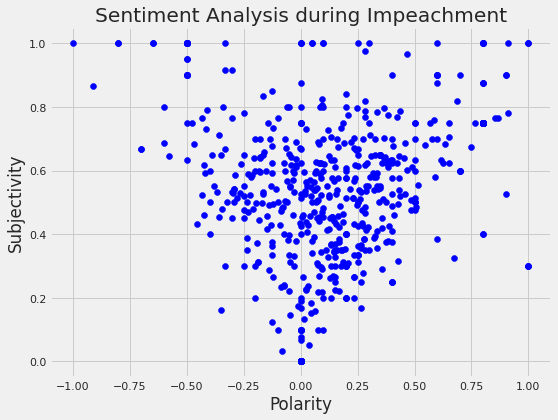

In [61]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(impeachment_tweets["Polarity"][i], impeachment_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during Impeachment') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [62]:
impeachment_tweets

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
40091,1190067978089439239,The home of Nancy Pelosi I cant believe her voters can be happy with the job she and the Do Nothing Democrats are doing San Francisco has really gone down hill So sad,19889,71150,01:48:11,2019-11-01,1,11,2019,11-2019,0.622222,0.086111,Positive
40092,1190079191355670529,1600 Pennsylvania Avenue the White House is the place I have come to love and will stay for hopefully another 5 years as we MAKE AMERICA GREAT AGAIN but my family and I will be making Palm Beach Florida our Permanent Residence I cherish New York and the people of,23414,110209,02:32:44,2019-11-01,1,11,2019,11-2019,0.451136,0.359091,Positive
40093,1190079192358105088,New York and always will but unfortunately despite the fact that I pay millions of dollars in city state and local taxes each year I have been treated very badly by the political leaders of both the city and state Few have been treated worse I hated having to make,14888,75739,02:32:44,2019-11-01,1,11,2019,11-2019,0.477652,-0.346705,Negative
40094,1190079193582899200,this decision but in the end it will be best for all concerned As President I will always be there to help New York and the great people of New York It will always have a special place in my heart,15257,80248,02:32:45,2019-11-01,1,11,2019,11-2019,0.506104,0.485974,Positive
40095,1190085372815929344,Thank you,15105,64505,02:57:18,2019-11-01,1,11,2019,11-2019,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40879,1210188790008037376,Nancy Pelosi has no leverage over the Senate Mitch McConnell did not nose his way into the impeachment process in the House and she has no standing in the Senate Brad Blakeman Crazy Nancy should clean up her filthy dirty District help the homeless there A primary for N,22872,93141,14:21:06,2019-12-26,26,12,2019,12-2019,0.780000,-0.246667,Negative
40880,1210207810291671045,Despite all of the great success that our Country has had over the last 3 years it makes it much more difficult to deal with foreign leaders and others when I am having to constantly defend myself against the Do Nothing Democrats their bogus Impeachment Scam Bad for USA,28363,124215,15:36:41,2019-12-26,26,12,2019,12-2019,0.430208,0.034375,Positive
40881,1210220021433208832,Russia Syria and Iran are killing or on their way to killing thousands of innocent civilians in Idlib Province Dont do it Turkey is working hard to stop this carnage,22822,107003,16:25:12,2019-12-26,26,12,2019,12-2019,0.620833,0.104167,Positive
40882,1210299694880088065,Trump stock market rally is far outpacing past US presidents,19438,82312,21:41:48,2019-12-26,26,12,2019,12-2019,0.625000,-0.075000,Negative


In [64]:
mean_subjectivity = impeachment_tweets.groupby("Date")['Subjectivity'].mean()
mean_subjectivity

Date
2019-11-01    0.464643
2019-11-02    0.518828
2019-11-03    0.580042
2019-11-04    0.380076
2019-11-05    0.483243
2019-11-06    0.436419
2019-11-07    0.398047
2019-11-08    0.200000
2019-11-09    0.290167
2019-11-10    0.532899
2019-11-11    0.425850
2019-11-12    0.487390
2019-11-13    0.402396
2019-11-14    0.463440
2019-11-15    0.299561
2019-11-16    0.364464
2019-11-17    0.316818
2019-11-18    0.269949
2019-11-19    0.247134
2019-11-20    0.312911
2019-11-21    0.310836
2019-11-22    0.271238
2019-11-23    0.459738
2019-11-24    0.348723
2019-11-25    0.431311
2019-11-26    0.397744
2019-11-27    0.103693
2019-11-28    1.000000
2019-11-29    0.187500
2019-11-30    0.000000
2019-12-01    0.318636
2019-12-02    0.498422
2019-12-03    0.721645
2019-12-04    0.374132
2019-12-05    0.412136
2019-12-06    0.492659
2019-12-07    0.580992
2019-12-08    0.387701
2019-12-09    0.194444
2019-12-10    0.525733
2019-12-11    0.443434
2019-12-12    0.505341
2019-12-13    0.522058
2019-1

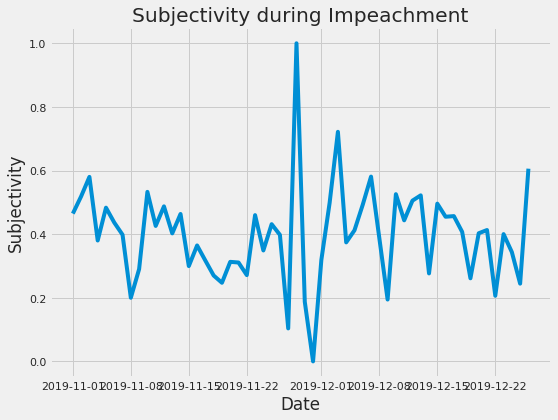

In [65]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity) 
plt.title('Subjectivity during Impeachment') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

In [66]:
mean_polarity = impeachment_tweets.groupby("Date")['Polarity'].mean()
mean_polarity

Date
2019-11-01    0.109826
2019-11-02    0.007841
2019-11-03    0.057104
2019-11-04    0.079730
2019-11-05    0.095806
2019-11-06    0.285364
2019-11-07    0.107258
2019-11-08    0.233333
2019-11-09    0.145019
2019-11-10    0.093906
2019-11-11    0.156152
2019-11-12    0.159906
2019-11-13   -0.053129
2019-11-14   -0.048862
2019-11-15    0.034329
2019-11-16    0.278886
2019-11-17    0.028913
2019-11-18    0.101919
2019-11-19    0.122338
2019-11-20    0.190830
2019-11-21    0.068995
2019-11-22    0.103528
2019-11-23    0.091076
2019-11-24    0.018236
2019-11-25    0.158500
2019-11-26    0.169094
2019-11-27    0.001420
2019-11-28    0.800000
2019-11-29    0.200000
2019-11-30    0.000000
2019-12-01    0.240909
2019-12-02    0.157967
2019-12-03    0.449351
2019-12-04    0.129036
2019-12-05    0.197584
2019-12-06   -0.014484
2019-12-07    0.129532
2019-12-08    0.070953
2019-12-09    0.216667
2019-12-10    0.164556
2019-12-11    0.034091
2019-12-12    0.097599
2019-12-13    0.130088
2019-1

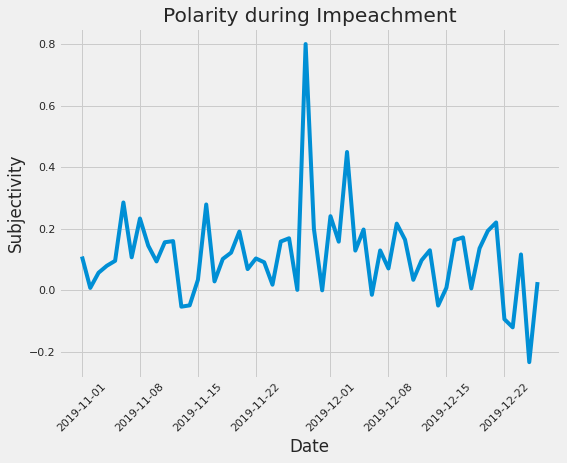

In [68]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity) 
plt.title('Polarity during Impeachment') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

In [69]:
impeachment_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2019-11-01')]
impeachment_stock_data = impeachment_stock_data[impeachment_stock_data['Date'] <= pd.to_datetime('2019-12-26')]
impeachment_stock_data["Daily Change"] = impeachment_stock_data['Close'] - impeachment_stock_data['Open']
impeachment_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
750,2019-11-01,100.46,100.46,98.67,99.23,97.54,543600,-1.23
751,2019-11-04,99.73,99.78,98.53,98.59,96.91,553200,-1.14
752,2019-11-05,98.92,99.06,97.90,98.42,96.74,518300,-0.50
753,2019-11-06,98.16,100.08,97.98,99.92,98.22,678200,1.76
754,2019-11-07,100.44,100.67,99.16,100.53,98.82,959300,0.09


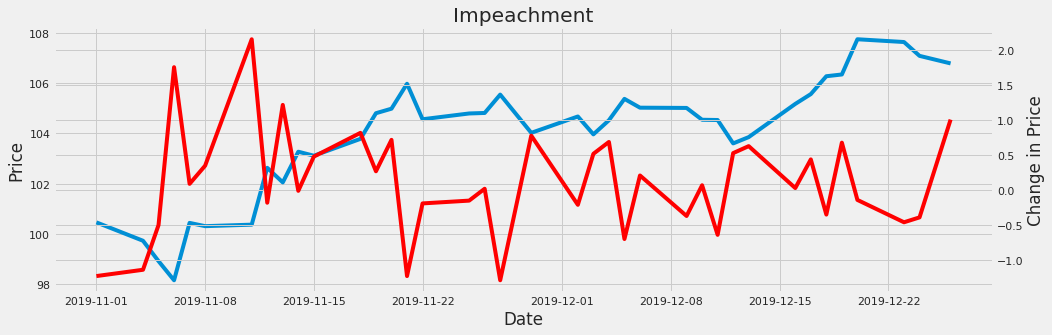

In [76]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2)
ax1.plot(impeachment_stock_data['Date'], impeachment_stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title('Impeachment')
ax2 = ax1.twinx()
#plt.subplots_adjust(hspace=0.3)
ax2.plot(impeachment_stock_data['Date'],  impeachment_stock_data['Daily Change'], color='red')
ax2.set_xlabel("Date")
ax2.set_ylabel("Change in Price")
#ax2.set_title('Daily Price Change during Impeachment')
plt.show()

### The Government Shutdown

In [77]:
shutdown_tweets = tweets[tweets['Date'] >= pd.to_datetime('2018-12-10')]
shutdown_tweets = shutdown_tweets[shutdown_tweets['Date'] <= pd.to_datetime('2019-02-26')]
shutdown_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
36161,1071939400517500929,I am in the process of interviewing some really great people for the position of White House Chief of Staff Fake News has been saying with certainty it was Nick Ayers a spectacular person who will always be with our MAGA agenda I will be making a decision soon,15206,80607,02:27:23,2018-12-10,10,12,2018,12-2018,0.662500,0.225000,Positive
36162,1072095127894667265,Democrats cant find a Smocking Gun tying the Trump campaign to Russia after James Comeys testimony No Smocking GunNo Collusion FoxNews Thats because there was NO COLLUSION So now the Dems go to a simple private transaction wrongly call it a campaign contribution,22253,96987,12:46:11,2018-12-10,10,12,2018,12-2018,0.544048,-0.166667,Negative
36163,1072098604599394305,which it was not but even if it was it is only a CIVIL CASE like Obamas but it was done correctly by a lawyer and there would not even be a fine Lawyers liability if he made a mistake not me Cohen just trying to get his sentence reduced WITCH HUNT,20169,93307,13:00:00,2018-12-10,10,12,2018,12-2018,0.750000,0.208333,Positive
36164,1072312854307581953,James Comeys behind closed doors testimony reveals that there was not evidence of Campaign Collusion with Russia when he left the FBI In other words the Witch Hunt is illegal and should never have been started,23817,98892,03:11:21,2018-12-11,11,12,2018,12-2018,0.335000,-0.225000,Negative
36165,1072317149723717632,Former FBI Director James Comey under fire for his testimony acknowledging he knew that the Democrats paid for that phony Trump Dossier LouDobbs Details on Tuesday night,18389,74922,03:28:25,2018-12-11,11,12,2018,12-2018,0.000000,0.000000,Neutral


In [78]:
print('Printing positive tweets:\n')
j=1
sortedDF = shutdown_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing positive tweets:

1) productive talks I will be delaying the US increase in tariffs now scheduled for March 1 Assuming both sides make additional progress we will be planning a Summit for President Xi and myself at MaraLago to conclude an agreement A very good weekend for US  China

2) Thank you Andrew  We all miss beautiful Meadow 

3) Thank you to Sean Parnell for the nice comments on  foxandfriends about the troops wonderful reaction to Melania and I in Iraq and Germany Great things are happening

4) Great Tweet today by Tyler Q Houlton  SpoxDHS on the FakeNews being put out by  CNN a proud member of the Opposition Party  TSA is doing a great job

5) Great analysis by  foxandfriends

6) So great being with you both in the Oval Office 

7) MAKE AMERICA GREAT AGAIN

8) Great unity in the Republican Party Want to once and for all put an end to stoppable crime and drugs Border Security and Wall No doubt

9) Congratulations to President  JairBolsonaro who just made a great inaug

In [79]:
print('Printing negative tweets:\n')
j=1
sortedDF = shutdown_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing negative tweets:

1) Starting the long overdue pullout from Syria while hitting the little remaining ISIS territorial caliphate hard and from many directions Will attack again from existing nearby base if it reforms Will devastate Turkey economically if they hit Kurds Create 20 mile safe zone

2) I inherited a total mess in Syria and Afghanistan the Endless Wars of unlimited spending and death During my campaign I said very strongly that these wars must finally end We spend 50 Billion a year in Afghanistan and have hit them so hard that we are now talking peace

3) Wow 19000 Texts between Lisa Page and her lover Peter S of the FBI in charge of the Russia Hoax were just reported as being wiped clean and gone Such a big story that will never be covered by the Fake News Witch Hunt

4) So funny to watch people who have failed for years they got NOTHING telling me how to negotiate with North Korea But thanks anyway

5) I am in the White House waiting for the Democrats to come on ov

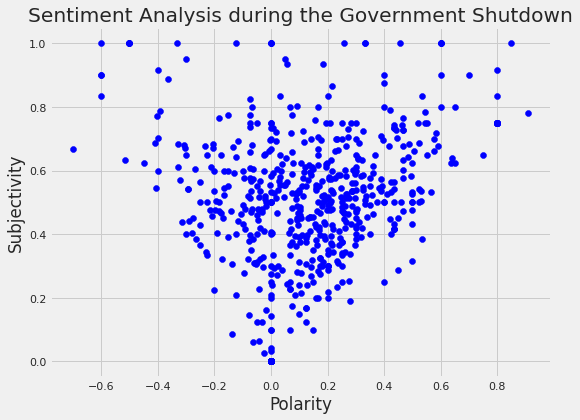

In [80]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(shutdown_tweets["Polarity"][i], shutdown_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during the Government Shutdown') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [81]:
mean_subjectivity = impeachment_tweets.groupby("Date")['Subjectivity'].mean()
mean_subjectivity

Date
2019-11-01    0.464643
2019-11-02    0.518828
2019-11-03    0.580042
2019-11-04    0.380076
2019-11-05    0.483243
2019-11-06    0.436419
2019-11-07    0.398047
2019-11-08    0.200000
2019-11-09    0.290167
2019-11-10    0.532899
2019-11-11    0.425850
2019-11-12    0.487390
2019-11-13    0.402396
2019-11-14    0.463440
2019-11-15    0.299561
2019-11-16    0.364464
2019-11-17    0.316818
2019-11-18    0.269949
2019-11-19    0.247134
2019-11-20    0.312911
2019-11-21    0.310836
2019-11-22    0.271238
2019-11-23    0.459738
2019-11-24    0.348723
2019-11-25    0.431311
2019-11-26    0.397744
2019-11-27    0.103693
2019-11-28    1.000000
2019-11-29    0.187500
2019-11-30    0.000000
2019-12-01    0.318636
2019-12-02    0.498422
2019-12-03    0.721645
2019-12-04    0.374132
2019-12-05    0.412136
2019-12-06    0.492659
2019-12-07    0.580992
2019-12-08    0.387701
2019-12-09    0.194444
2019-12-10    0.525733
2019-12-11    0.443434
2019-12-12    0.505341
2019-12-13    0.522058
2019-1

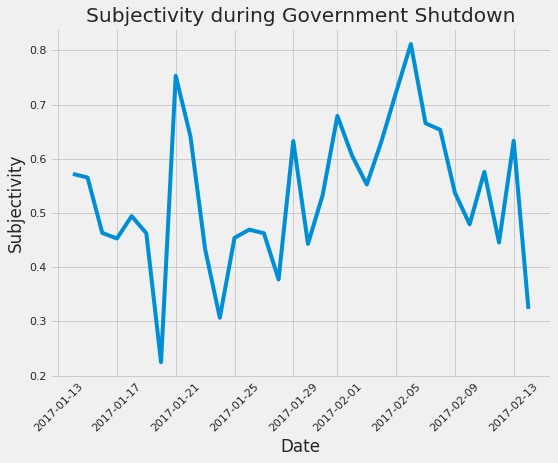

In [101]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity) 
plt.title('Subjectivity during Government Shutdown') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

In [84]:
mean_polarity = impeachment_tweets.groupby("Date")['Polarity'].mean()
mean_polarity

Date
2019-11-01    0.109826
2019-11-02    0.007841
2019-11-03    0.057104
2019-11-04    0.079730
2019-11-05    0.095806
2019-11-06    0.285364
2019-11-07    0.107258
2019-11-08    0.233333
2019-11-09    0.145019
2019-11-10    0.093906
2019-11-11    0.156152
2019-11-12    0.159906
2019-11-13   -0.053129
2019-11-14   -0.048862
2019-11-15    0.034329
2019-11-16    0.278886
2019-11-17    0.028913
2019-11-18    0.101919
2019-11-19    0.122338
2019-11-20    0.190830
2019-11-21    0.068995
2019-11-22    0.103528
2019-11-23    0.091076
2019-11-24    0.018236
2019-11-25    0.158500
2019-11-26    0.169094
2019-11-27    0.001420
2019-11-28    0.800000
2019-11-29    0.200000
2019-11-30    0.000000
2019-12-01    0.240909
2019-12-02    0.157967
2019-12-03    0.449351
2019-12-04    0.129036
2019-12-05    0.197584
2019-12-06   -0.014484
2019-12-07    0.129532
2019-12-08    0.070953
2019-12-09    0.216667
2019-12-10    0.164556
2019-12-11    0.034091
2019-12-12    0.097599
2019-12-13    0.130088
2019-1

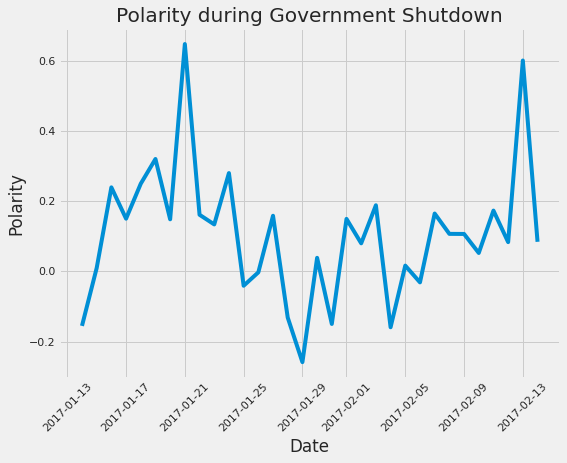

In [100]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity) 
plt.title('Polarity during Government Shutdown') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Polarity') 
plt.show()

In [87]:
shutdown_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2018-12-10')]
shutdown_stock_data = shutdown_stock_data[shutdown_stock_data['Date'] <= pd.to_datetime('2019-02-26')]
shutdown_stock_data["Daily Change"] = shutdown_stock_data['Close'] - shutdown_stock_data['Open']
shutdown_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
524,2018-12-10,87.36,87.36,85.11,87.10,83.93,1033500,-0.26
525,2018-12-11,88.26,89.62,87.24,87.31,84.13,858200,-0.95
526,2018-12-12,88.16,88.72,87.41,87.49,84.30,560300,-0.67
527,2018-12-13,87.41,87.68,86.40,87.02,84.27,584900,-0.39
528,2018-12-14,86.72,87.34,86.01,86.54,83.81,535900,-0.18


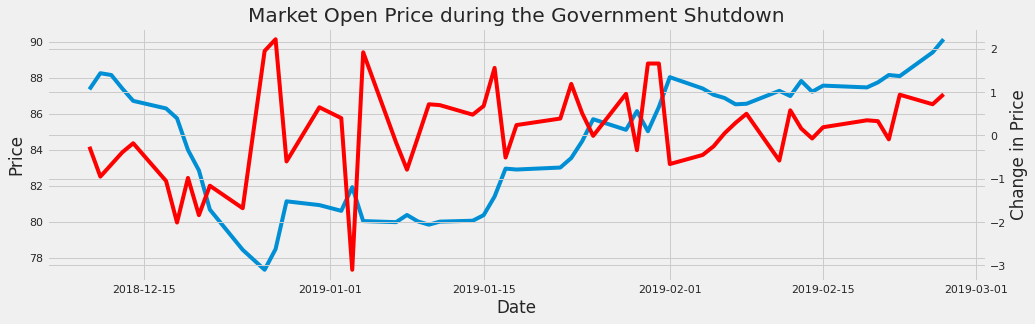

In [89]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2)
ax1.plot(shutdown_stock_data['Date'], shutdown_stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title('Market Open Price during the Government Shutdown')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()
ax2.plot(shutdown_stock_data['Date'], shutdown_stock_data['Daily Change'], color = "red")
ax2.set_xlabel("Date")
ax2.set_ylabel("Change in Price")
#ax2.set_title('Market Close Price during the Government Shutdown')
plt.show()

### The Dakota Access and Keystone XL pipelines approval



In [90]:
dakota_tweets = tweets[tweets['Date'] >= pd.to_datetime('2017-01-14')]
dakota_tweets = dakota_tweets[dakota_tweets['Date'] <= pd.to_datetime('2017-02-14')]
dakota_tweets.head()

,id,content,retweets,favorites,Time,Date,Day,Month,Year,Month_Year,Subjectivity,Polarity,Analysis
31214,820251730407473153,Congressman John Lewis should spend more time on fixing and helping his district which is in horrible shape and falling apart not to,17884,77341,13:50:26,2017-01-14,14,1,2017,1-2017,0.750000,-0.250000,Negative
31215,820255947956383744,mention crime infested rather than falsely complaining about the election results All talk talk talk no action or results Sad,13992,67390,14:07:12,2017-01-14,14,1,2017,1-2017,0.566667,-0.316667,Negative
31216,820257714362314753,INTELLIGENCE INSIDERS NOW CLAIM THE TRUMP DOSSIER IS A COMPLETE FRAUD OANN,16134,59755,14:14:13,2017-01-14,14,1,2017,1-2017,0.400000,0.100000,Positive
31217,820425770925338624,Congressman John Lewis should finally focus on the burning and crime infested innercities of the US I can use all the help I can get,18773,83963,01:22:01,2017-01-15,15,1,2017,1-2017,1.000000,0.000000,Neutral
31218,820450166331346944,Inauguration Day is turning out to be even bigger than expected January 20th Washington DC Have fun,21309,107301,02:58:57,2017-01-15,15,1,2017,1-2017,0.275000,0.050000,Positive


In [91]:
print('Printing positive tweets:\n')
j=1
sortedDF = dakota_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing positive tweets:

1) Looking forward to a speedy recovery for George and Barbara Bush both hospitalized Thank you for your wonderful letter

2) Thank you for a wonderful evening in Washington DC Inauguration

3) Wonderful meeting with Canadian PM  JustinTrudeau and a group of leading CEOs  business women from Canadaand the United States

4) An honor having the National Sheriffs Assoc join me at the  WhiteHouse Incredible men  women who protect  serve 247365 THANK YOU

5) THANK YOU for another wonderful evening in Washington DC TOGETHER we will MAKE AMERICA GREAT AGAIN

6) Attending Chief Ryan Owens Dignified Transfer yesterday with my daughter Ivanka was my great honor To a great and brave man  thank you

7) Great seeing  TheLeeGreenwood and Kimberly at this evenings VP dinner GodBlessTheUSA

8) People are pouring into Washington in record numbers Bikers for Trump are on their way It will be a great Thursday Friday and Saturday

9) MAKE AMERICA GREAT AGAIN

10) Great meeting w

In [92]:
print('Printing negative tweets:\n')
j=1
sortedDF = dakota_tweets.sort_values(by=['Polarity'], ascending=False) 
for i in list(sortedDF.index):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['content'][i])
    print()
    j=j+1

Printing negative tweets:

1) Sen McCain should not be talking about the success or failure of a mission to the media Only emboldens the enemy Hes been losing so

2) A new radical Islamic terrorist has just attacked in Louvre Museum in Paris Tourists were locked down France on edge again GET SMAUS

3) It wasnt Donald Trump that divided this country this country has been divided for a long time Stated today by Reverend Franklin Graham

4) As your President I have no higher duty than to protect the lives of the American people

5) Statement Regarding Recent Executive Order Concerning Extreme Vetting 

6) Just leaving Florida Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention Very dishonest

7) Look forward to seeing final results of VoteStand Gregg Phillips and crew say at least 3000000 votes were illegal We must do better

8) The failing  nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win Now

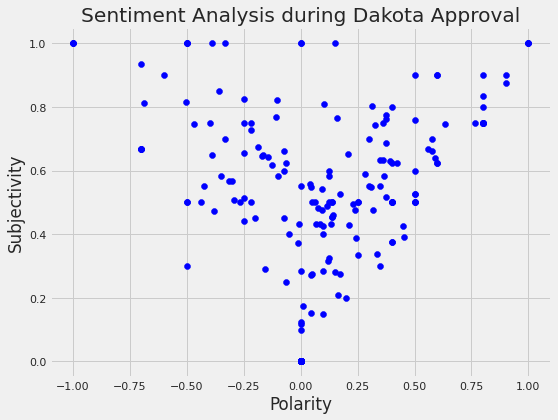

In [93]:
plt.figure(figsize=(8,6)) 
for i in list(sortedDF.index):
  plt.scatter(dakota_tweets["Polarity"][i], dakota_tweets["Subjectivity"][i], color='Blue') 
plt.title('Sentiment Analysis during Dakota Approval') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [94]:
mean_subjectivity = dakota_tweets.groupby("Date")['Subjectivity'].mean()
mean_subjectivity

Date
2017-01-14    0.572222
2017-01-15    0.565476
2017-01-16    0.463333
2017-01-17    0.453006
2017-01-18    0.494306
2017-01-19    0.462674
2017-01-20    0.224817
2017-01-21    0.753125
2017-01-22    0.641667
2017-01-23    0.433333
2017-01-24    0.306818
2017-01-25    0.454196
2017-01-26    0.469271
2017-01-27    0.462753
2017-01-28    0.377381
2017-01-29    0.632798
2017-01-30    0.442963
2017-01-31    0.533333
2017-02-01    0.679167
2017-02-02    0.605777
2017-02-03    0.552578
2017-02-04    0.632374
2017-02-05    0.723148
2017-02-06    0.811756
2017-02-07    0.665667
2017-02-08    0.653535
2017-02-09    0.537227
2017-02-10    0.479167
2017-02-11    0.575926
2017-02-12    0.445617
2017-02-13    0.633333
2017-02-14    0.322980
Name: Subjectivity, dtype: float64

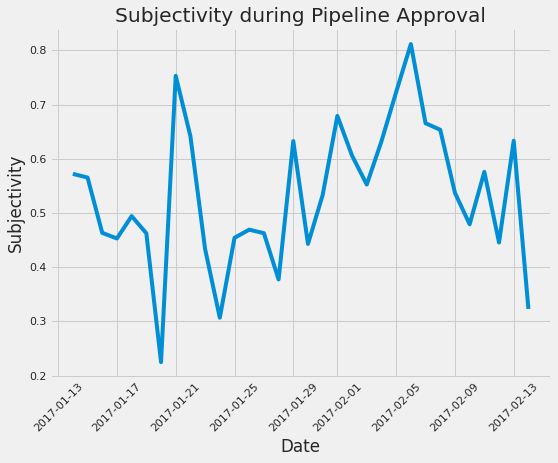

In [102]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_subjectivity) 
plt.title('Subjectivity during Pipeline Approval') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Subjectivity') 
plt.show()

In [96]:
mean_polarity = dakota_tweets.groupby("Date")['Polarity'].mean()
mean_polarity

Date
2017-01-14   -0.155556
2017-01-15    0.009131
2017-01-16    0.238889
2017-01-17    0.149684
2017-01-18    0.249271
2017-01-19    0.319618
2017-01-20    0.147940
2017-01-21    0.646875
2017-01-22    0.160833
2017-01-23    0.133333
2017-01-24    0.279545
2017-01-25   -0.041257
2017-01-26   -0.003125
2017-01-27    0.158065
2017-01-28   -0.131786
2017-01-29   -0.258810
2017-01-30    0.038207
2017-01-31   -0.150000
2017-02-01    0.149091
2017-02-02    0.079545
2017-02-03    0.187915
2017-02-04   -0.159405
2017-02-05    0.016019
2017-02-06   -0.031622
2017-02-07    0.164333
2017-02-08    0.106457
2017-02-09    0.106187
2017-02-10    0.052083
2017-02-11    0.172685
2017-02-12    0.082890
2017-02-13    0.600000
2017-02-14    0.083838
Name: Polarity, dtype: float64

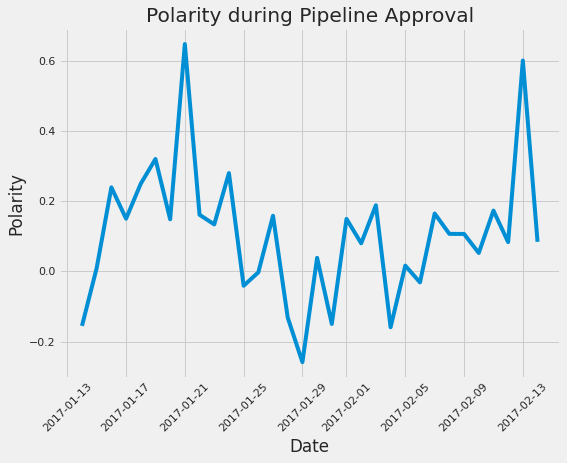

In [103]:
plt.figure(figsize=(8,6)) 
plt.plot(mean_polarity) 
plt.title('Polarity during Pipeline Approval') 
plt.xlabel('Date') 
plt.xticks(rotation = 45)
plt.ylabel('Polarity') 
plt.show()

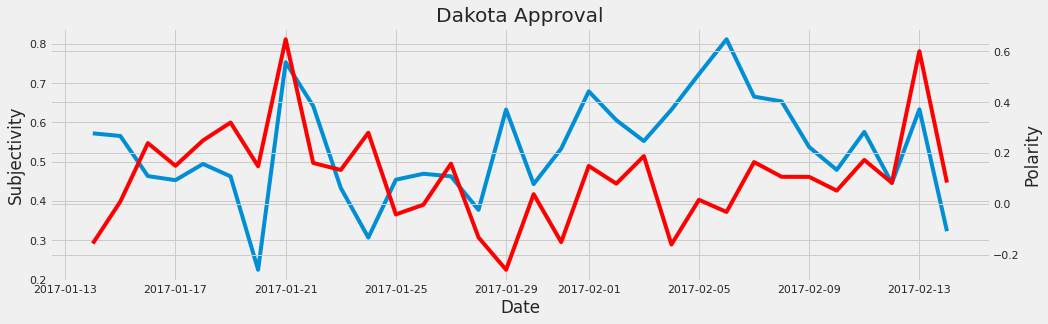

In [121]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2)
ax1.plot(mean_subjectivity)
ax1.set_xlabel("Date")
ax1.set_ylabel("Subjectivity")
ax1.set_title('Dakota Approval')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()
ax2.plot(mean_polarity, color = "red")
#ax2.set_xlabel("Date")
ax2.set_ylabel("Polarity")
#ax2.set_title('Market Close Price during Dakota Approval')
plt.show()

In [98]:
dakota_stock_data = stock_data[stock_data['Date'] >= pd.to_datetime('2017-01-14')]
dakota_stock_data["Daily Change"] = dakota_stock_data['Close'] - dakota_stock_data['Open']
dakota_stock_data = dakota_stock_data[dakota_stock_data['Date'] <= pd.to_datetime('2017-02-17')]
dakota_stock_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Open,High,Low,Close,Adj Close,Volume,Daily Change
46,2017-01-17,67.36,67.68,66.89,66.99,62.40,908800,-0.37
47,2017-01-18,66.71,67.29,66.62,67.25,62.65,777600,0.54
48,2017-01-19,67.06,67.34,66.49,67.06,62.47,625000,0.00
49,2017-01-20,67.30,67.58,66.84,67.36,62.75,637800,0.06
50,2017-01-23,67.06,67.68,66.67,67.32,62.71,629700,0.26


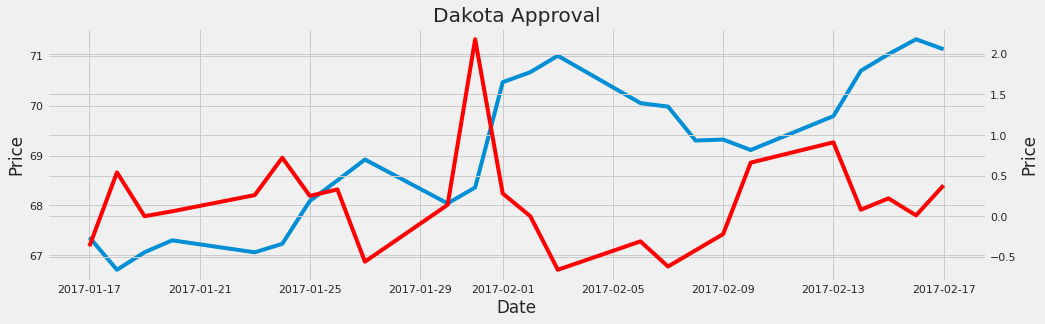

In [104]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
#ax2 = fig.add_subplot(2,1,2)
ax1.plot(dakota_stock_data['Date'], dakota_stock_data['Open'])
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title('Dakota Approval')
plt.subplots_adjust(hspace=0.3)
ax2 = ax1.twinx()
ax2.plot(dakota_stock_data['Date'], dakota_stock_data['Daily Change'], color = "red")
ax2.set_xlabel("Date")
ax2.set_ylabel("Price")
#ax2.set_title('Market Close Price during Dakota Approval')
plt.show()